In [1]:
!pip install git+https://github.com/qubvel/efficientnet

  Cloning https://github.com/qubvel/efficientnet to /tmp/pip-req-build-gzq9ixd8
  Running command git clone -q https://github.com/qubvel/efficientnet /tmp/pip-req-build-gzq9ixd8
     |████████████████████████████████| 50 kB 3.5 MB/s 
  Created wheel for efficientnet: filename=efficientnet-1.1.0-py3-none-any.whl size=18326 sha256=aa4e37c1d8fdc23f92ee54ff671dec090d881978f471e0160db1538b5a27884c
  Stored in directory: /tmp/pip-ephem-wheel-cache-aum4d04a/wheels/11/69/85/814d64d694c96db0eef17b718042d644a1e54f113920481920
Successfully built efficientnet


In [2]:
import numpy as np
import pandas as pd 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2

import tensorflow as tf
from tensorflow.keras.applications.xception import Xception
import efficientnet.keras as efn
from keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import os
print(os.listdir("../input"))

['shopee-object-detection-outlier', 'shopee-product-detection-open']


Using TensorFlow backend.


In [3]:
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


In [4]:
from kaggle_datasets import KaggleDatasets
# For tf.dataset
AUTO = tf.data.experimental.AUTOTUNE

# Data access
GCS_DS_PATH = KaggleDatasets().get_gcs_path("shopee-product-detection-open")

# Configuration
# EPOCHS = 27
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
print(BATCH_SIZE)

128


In [5]:
# Constant
DIM=299 # image size
IMAGE_SIZE=(DIM, DIM)
IMAGE_CHANNELS=3
# BATCH_SIZE=20

In [6]:
# # Prepare training data
# categories = os.listdir("../input/shopee-product-detection-open/train/train/train/")
# df = pd.DataFrame(columns = ['filename', 'category'])
# for i in categories:
#     filenames = os.listdir("../input/shopee-product-detection-open/train/train/train/"+str(i))
#     dx = pd.DataFrame({'filename': filenames})
#     dx['category'] = i
#     df = df.append(dx, ignore_index=True)
    
# # Change the category to int
# df['filename'] = df.category + "/" +df.filename
# # df['category'] = df['category'].astype(int)

# # Training data is ready in df
# df.head()

In [7]:
df = pd.read_csv("../input/shopee-product-detection-open/train.csv")
df['category'] = df.category.astype(str)
df['category'] = df.category.apply(lambda x: x.zfill(2))
df['filename'] = df.category + "/" +df.filename

df.head()

,filename,category
0,03/45e2d0c97f7bdf8cbf3594beb6fdcda0.jpg,03
1,03/f74d1a5fc2498bbbfa045c74e3cc333e.jpg,03
2,03/f6c172096818c5fab10ecae722840798.jpg,03
3,03/251ffd610399ac00fea7709c642676ee.jpg,03
4,03/73c7328b8eda399199fdedec6e4badaf.jpg,03


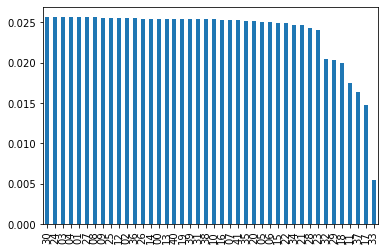

In [8]:
# Look into training data
df.category.value_counts(normalize=True).sort_values(ascending=False).plot.bar()
# The class mostly have balance samples, except for category 32, 29, 18, 11, 37, 17, mostly 33

This image belong to category:  38


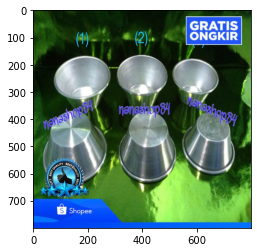

In [9]:
# Get 1 sample
sample = df.sample()[['filename', 'category']].values
img = "../input/shopee-product-detection-open/train/train/train/"+str(sample[0][0])
image = cv2.imread(img)
plt.imshow(image)
print("This image belong to category: ", sample[0][1])

### Detect Duplicates

In [10]:
# # Detect duplicates in Images

# def dhash(image, hashSize=16):
#     # convert the image to grayscale and resize the grayscale image,
#     # adding a single column (width) so we can compute the horizontal
#     # gradient
# #     gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#     gray = image
#     resized = cv2.resize(gray, (hashSize + 1, hashSize))
#     # compute the (relative) horizontal gradient between adjacent
#     # column pixels
#     diff = resized[:, 1:] > resized[:, :-1]
#     # convert the difference image to a hash and return it
#     return sum([2 ** i for (i, v) in enumerate(diff.flatten()) if v])

# basic_path = "../input/shopee-product-detection-open/train/train/train/"
# image_paths = df['filename'].tolist()

# hashes = {}

# # loop over our image paths
# for imagePath in image_paths:
#     totalPath = basic_path + imagePath
#     # load the input image and compute the hash
#     image = cv2.imread(totalPath)
#     h = dhash(image)
#     # grab all image paths with that hash, add the current image
#     # path to it, and store the list back in the hashes dictionary
#     p = hashes.get(h, [])
#     p.append(imagePath)
#     hashes[h] = p

# print('Check duplicates complete')

In [11]:
# # convert dictionary to lists of hashes and filenames
# hash_list = []
# file_list = []
# for (h, hashedPaths) in hashes.items():
#     if len(hashedPaths) > 1:
#         for i in range(len(hashedPaths)):
#             hash_list.append(h)
#             file_list.append(hashedPaths[i])
            
# # store in dataframe
# data= {'hash': hash_list, 'images': file_list}
# df_hash = pd.DataFrame(data=data)
# df_hash.head(5)

In [12]:
# # store in dataframe
# data= {'hash': hash_list, 'images': file_list}
# df_hash = pd.DataFrame(data=data)
# df_hash['category'] = df_hash.images.apply(lambda x: x.split("/")[0])

# # save duplicates df to csv
# df_hash.to_csv("shopee_duplicates_image_rgb.csv", index=False)

# # see samples
# df_hash.head(5)

In [13]:
# read detected duplicate
df_hash = pd.read_csv("../input/shopee-object-detection-outlier/shopee_duplicates_image_rgb.csv")
df_hash['category'] = df_hash.images.apply(lambda x: x.split("/")[0])
df_hash.head()

,hash,images,category
0,1840677840181574508287741969065075941002881063...,20/077fc510602c524498f8cc737696cbc0.jpg,20
1,1840677840181574508287741969065075941002881063...,20/69172127768226f92412764a97fbef64.jpg,20
2,1178270441946839851679533312658549906877832370...,20/69feea287a16a43d92415f0a81b43739.jpg,20
3,1178270441946839851679533312658549906877832370...,20/c1ea65f11a930b8d44304ffb6b0370be.jpg,20
4,1717844022201745734259788443007738239667158539...,20/ad042b4295d51bca2173527430535447.jpg,20


In [14]:
# get number of unique category in each hash
n_unique = df_hash[['hash','category']].groupby('hash').nunique()['category'].reset_index()

# join to df_hash
df_hash = df_hash.merge(n_unique, on='hash', how='left')
df_hash.head()

,hash,images,category_x,category_y
0,1840677840181574508287741969065075941002881063...,20/077fc510602c524498f8cc737696cbc0.jpg,20,1
1,1840677840181574508287741969065075941002881063...,20/69172127768226f92412764a97fbef64.jpg,20,1
2,1178270441946839851679533312658549906877832370...,20/69feea287a16a43d92415f0a81b43739.jpg,20,1
3,1178270441946839851679533312658549906877832370...,20/c1ea65f11a930b8d44304ffb6b0370be.jpg,20,1
4,1717844022201745734259788443007738239667158539...,20/ad042b4295d51bca2173527430535447.jpg,20,1


found duplicates image in these paths ['20/aa35bacd3dbe73a334054efd87e88c81.jpg', '41/925643426f979b65394b027249ae40ef.jpg']


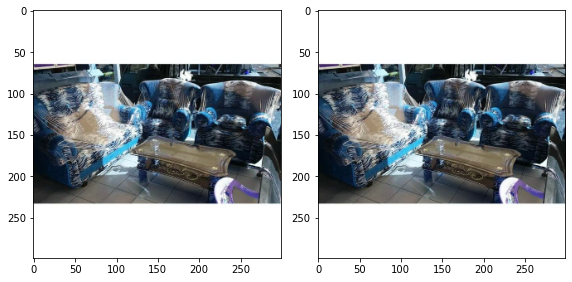

In [15]:
# show duplicates image
# get random hash
h = df_hash[(df_hash.category_y > 1) & (df_hash.hash != 0)].sample().iloc[0,0]

imgs = df_hash[df_hash.hash == h]['images'].tolist()
print('found duplicates image in these paths', imgs)

basic_path = "../input/shopee-product-detection-open/train/train/train/"
plt.figure(figsize=(12, 12))
for i in range(0, len(imgs)):
    plt.subplot(len(imgs)//2, 3, i+1)
    for p in imgs:
        total_path = basic_path + p
        image = cv2.imread(total_path)
        image = cv2.resize(image, (299, 299))
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [16]:
# Eliminate only duplicates in training data
df = pd.merge(df, df_hash[df_hash.category_y > 1], how='outer', left_on = "filename", right_on= "images", indicator=True)

# there are 25 images in training data that we will drop
# df_train[df_train._merge=="both"].category.count()

df = df[df._merge=="left_only"]

In [17]:
# Revert back information as train csv
df['filename'] = df['filename'].apply(lambda x: x.split("/")[1])
df['category'] = df.category.astype(int)
df = df[['filename', 'category']]
df.head()

,filename,category
0,45e2d0c97f7bdf8cbf3594beb6fdcda0.jpg,3
1,f74d1a5fc2498bbbfa045c74e3cc333e.jpg,3
2,f6c172096818c5fab10ecae722840798.jpg,3
3,251ffd610399ac00fea7709c642676ee.jpg,3
4,73c7328b8eda399199fdedec6e4badaf.jpg,3


In [18]:
category_list = ['00', '01', '02', '03', '04', '05', '06', '07', '08', '09',
                 '10', '11', '12', '13', '14', '15', '16', '17', '18', '19',
                 '20', '21', '22', '23', '24', '25', '26', '27', '28', '29',
                 '30', '31', '32', '33', '34', '35', '36', '37', '38', '39',
                 '40', '41']

def get_path_and_label(df):
    # collect trainingset path
    train_df = df
    dataset_path = {}
    categories = np.sort(train_df['category'].astype(int).unique())
    for cat in categories:
            dataset_path[cat] = train_df[train_df['category'] == cat]['filename']

    train_paths = []
    labels = []

    for idx, key in enumerate(dataset_path.keys()):
        if key == idx:
            for path in dataset_path[idx]:
                train_paths.append(os.path.join(GCS_DS_PATH, 'train', 'train', 'train', category_list[idx], path))

    for label in dataset_path.keys():
        labels.extend([label] * len(dataset_path[label]))

    # convert to numpy array
    train_paths = np.array(train_paths)

    # convert to one-hot-encoding-labels
    train_labels = to_categorical(labels)
    
    return train_paths,train_labels

def get_path(df):
    test_df = df
    test_paths = []
    for path in test_df['filename']:
        test_paths.append(os.path.join(GCS_DS_PATH,  'test', 'test', 'test', path))
    test_paths = np.array(test_paths)
    return test_paths

In [19]:
# Get training, and test paths

train_paths, train_labels = get_path_and_label(df)

test_df = pd.read_csv("../input/shopee-product-detection-open/test.csv")
test_paths = get_path(test_df)

### Split Train Validataion Set

In [20]:
# Train Validation split
train_paths, valid_paths, train_labels, valid_labels = train_test_split(train_paths, 
                                                                        train_labels, 
                                                                        stratify=train_labels,
                                                                        test_size=0.1, 
                                                                        random_state=41)

train_paths.shape, valid_paths.shape, train_labels.shape, valid_labels.shape

((94825,), (10537,), (94825, 42), (10537, 42))

### Data Generator for TPU

In [21]:
# Preprocess image
def decode_image(filename, label=None, image_size=(299, 299)):
    bits = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(bits, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, image_size)
    
    if label is None:
        return image
    else:
        return image, label
    
def data_augment_h_flip(image, label=None):
    image = tf.image.random_flip_left_right(image)
    
    if label is None:
        return image
    else:
        return image, label

In [22]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((train_paths, train_labels))
    .map(decode_image, num_parallel_calls=AUTO)
    .map(data_augment_h_flip, num_parallel_calls=AUTO) # no augmentation applied
    .cache()
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((valid_paths, valid_labels))
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(test_paths)
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
)

## Build Model

### Define Model

In [23]:
pretrained = "EfficientNetB6"
# pretrained = "EfficientNetB5"
# pretrained = "Xception"

In [24]:
%%time

with strategy.scope():
    base_model = efn.EfficientNetB6(weights='imagenet', input_shape = (DIM, DIM, IMAGE_CHANNELS), include_top=False) 
#     base_model = efn.EfficientNetB4(weights='imagenet', input_shape = (DIM, DIM, IMAGE_CHANNELS), include_top=False) 
#     base_model = Xception(weights='imagenet', input_shape = (DIM, DIM, IMAGE_CHANNELS), include_top=False)
#     base_model = efn.EfficientNetB5(weights='imagenet', input_shape = (DIM, DIM, IMAGE_CHANNELS), include_top=False)
    # add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # let's add a logistic layer -- we have 42 classes
    predictions = Dense(42, activation='softmax')(x)

    # this is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)

    # compile the model
    model.compile(optimizer = Adam(learning_rate=0.00001), 
                  loss = 'categorical_crossentropy', 
                  metrics = ['accuracy'])
    
#     model.summary()

165527552/165527152 [==============================] - 6s 0us/step
CPU times: user 28.3 s, sys: 6.37 s, total: 34.6 s
Wall time: 47.7 s


### Define Learning Rate Scheduler

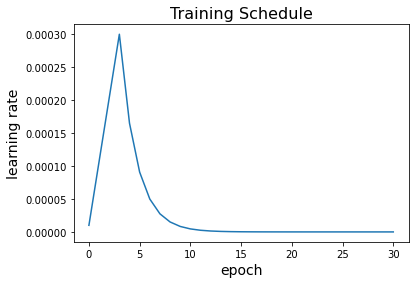

[1e-05, 0.00010666666666666665, 0.0002033333333333333, 0.0003, 0.000165, 9.075000000000001e-05, 4.9912500000000014e-05, 2.7451875000000006e-05, 1.5098531250000003e-05, 8.304192187500003e-06, 4.567305703125002e-06, 2.5120181367187515e-06, 1.3816099751953134e-06, 7.598854863574225e-07, 4.1793701749658236e-07, 2.2986535962312032e-07, 1.2642594779271618e-07, 6.953427128599391e-08, 3.824384920729665e-08, 2.103411706401316e-08, 1.156876438520724e-08, 6.362820411863982e-09, 3.4995512265251903e-09, 1.924753174588855e-09, 1.0586142460238702e-09, 5.822378353131287e-10, 3.2023080942222083e-10, 1.7612694518222146e-10, 9.686981985022181e-11, 5.3278400917622e-11, 2.9303120504692104e-11]


In [25]:
# CUSTOM LEARNING SCHEUDLE
EPOCH = 30
SUSTAIN_EPOCHS = 1
LR_START = 1e-5
LR_MAX = 3e-4
LR_RAMPUP_EPOCHS = 3
LR_SUSTAIN_EPOCHS = 0
LR_STEP_DECAY = 0.55

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = LR_MAX * LR_STEP_DECAY**((epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS)//SUSTAIN_EPOCHS)
    return lr
    
lr2 = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)

rng = [i for i in range(EPOCH+1)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y); 
plt.xlabel('epoch',size=14); plt.ylabel('learning rate',size=14)
plt.title('Training Schedule',size=16); plt.show()
print(y)

### Train Model

In [26]:
# train the model on the new data for a few epochs 
history = model.fit(train_dataset, 
                    steps_per_epoch = train_labels.shape[0] // BATCH_SIZE,
                    validation_data = valid_dataset,
                    validation_steps = valid_labels.shape[0] // BATCH_SIZE,
                    callbacks = [lr2], # apply learning rate scheduler
                    epochs=EPOCH )


Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/30
740/740 [==============================] - 2572s 3s/step - accuracy: 0.3033 - loss: 3.0484 - val_accuracy: 0.5586 - val_loss: 2.2533 - lr: 1.0000e-05

Epoch 00002: LearningRateScheduler reducing learning rate to 0.00010666666666666665.
Epoch 2/30
740/740 [==============================] - 216s 292ms/step - accuracy: 0.6899 - loss: 1.1770 - val_accuracy: 0.7778 - val_loss: 0.8188 - lr: 1.0667e-04

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0002033333333333333.
Epoch 3/30
740/740 [==============================] - 216s 291ms/step - accuracy: 0.7692 - loss: 0.8396 - val_accuracy: 0.7965 - val_loss: 0.7480 - lr: 2.0333e-04

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0003.
Epoch 4/30
740/740 [==============================] - 216s 292ms/step - accuracy: 0.8066 - loss: 0.6916 - val_accuracy: 0.8022 - val_loss: 0.7612 - lr: 3.0000e-04

Epoch 00005: LearningRateScheduler redu

In [27]:
# Save model
log = pretrained + "-batch"+ str(BATCH_SIZE) + "-size" + str(DIM) +"x"+ str(DIM) + "-epoch" + str(EPOCH) + "-dropduplicate-rgb" + "-LRexp-Sustain1" + "-Decay55" + ".h5"
print(log)
model.save(log)

EfficientNetB6-batch128-size299x299-epoch30-dropduplicate-rgb-LRexp-Sustain1-Decay55.h5


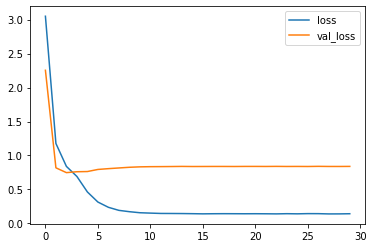

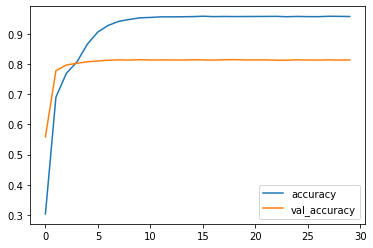

In [28]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['accuracy', 'val_accuracy']].plot()

## Prediction

In [29]:
# Predict Test
pred = model.predict(test_dataset, verbose=1)

96/96 [==============================] - 300s 3s/step


In [30]:
# prepare submission file
test_df = test_df.drop('category', axis=1)

# get class with maximum prediction
test_df['category'] = np.argmax(pred,axis=1)
# zero padding
test_df['category'] = test_df['category'].apply(lambda x: str(x).zfill(2))

# prepare sub
test_df.to_csv("submission.csv",index=False)

In [31]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12186 entries, 0 to 12185
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  12186 non-null  object
 1   category  12186 non-null  object
dtypes: object(2)
memory usage: 190.5+ KB


In [32]:
test_df.head()

,filename,category
0,fd663cf2b6e1d7b02938c6aaae0a32d2.jpg,20
1,c7fd77508a8c355eaab0d4e10efd6b15.jpg,27
2,127f3e6d6e3491b2459812353f33a913.jpg,04
3,5ca4f2da11eda083064e6c36f37eeb81.jpg,22
4,46d681a542f2c71be017eef6aae23313.jpg,12
